Test elastic problems using MFEANet

* Multi-phase elastic analysis
* Heterogeneous material system

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from data.dataset import MechanicalDataSet

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 1 # batch size
k = 0 # test data index
mode = 'elastic_pstress' # plane strain or plane stress
n_test = 2**6

test_set = MechanicalDataSet('data/data_Ti64/elastic_Ti64.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))
solution_test, f_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

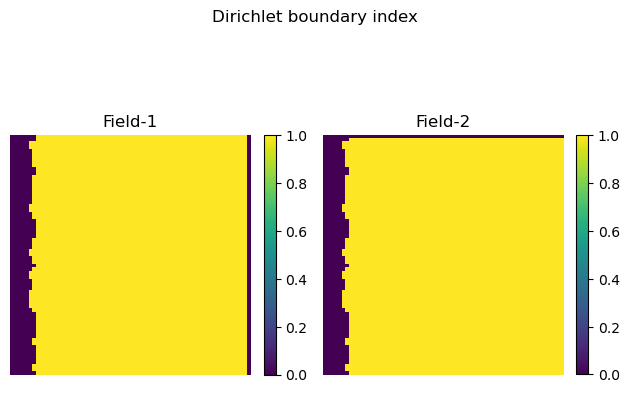

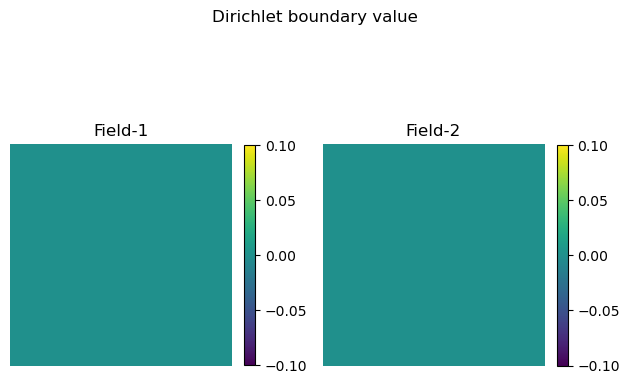

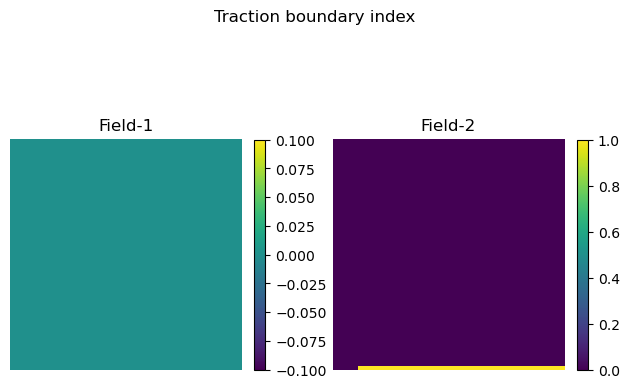

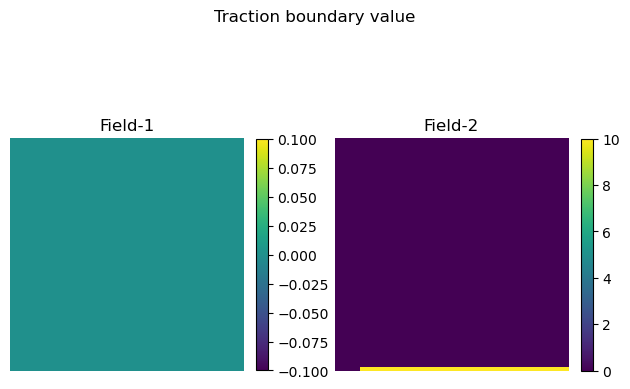

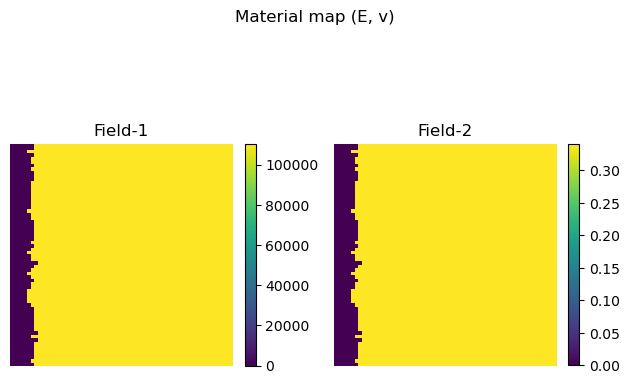

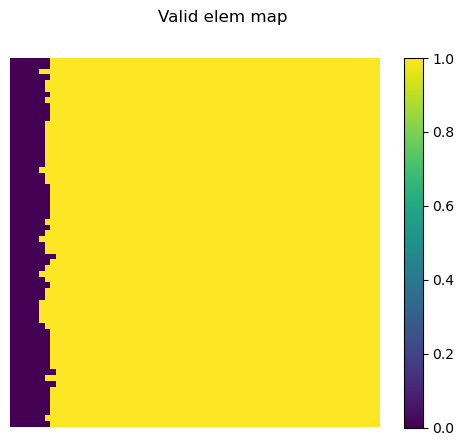

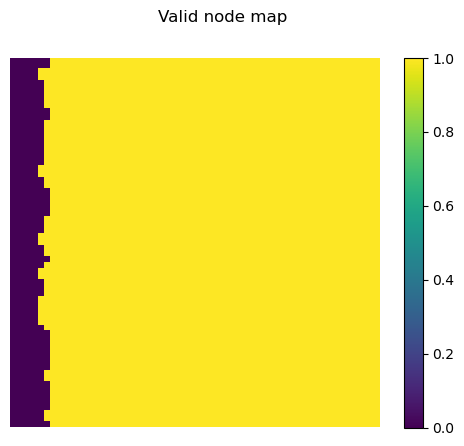

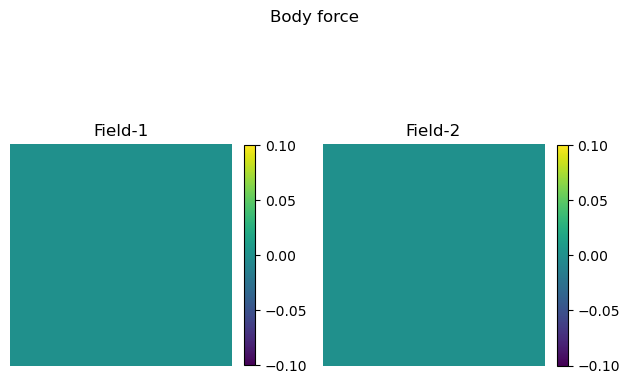

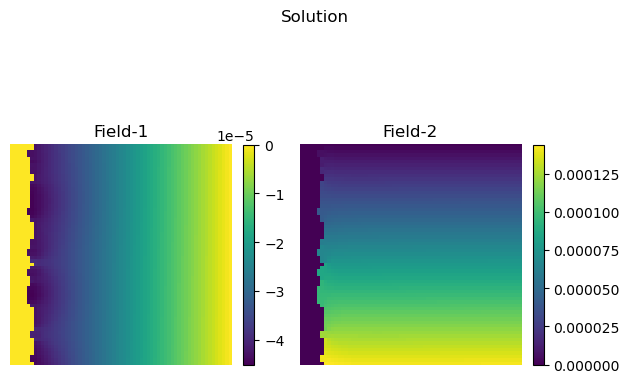

In [4]:
plot.plot_elasticfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_idx_test[k], ftitle='Traction boundary index')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_test[k], ftitle='Material map (E, v)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_elasticfield(f_test[k], ftitle='Body force')
plot.plot_elasticfield(u_test[k], ftitle='Solution')

In [5]:
n_elem = n_test
ku, kf = 2, 2
h = 0.0061*4
grid = SingleGrid(h, n_elem, mode, device_predict)

In [6]:
EPS = 1e-6
n_jac = 0
jacu_test = EPS*torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if (False):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, nmsk_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_conn_test)
        residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")

    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_elasticfield(jacu_test[0], "Benchmark")
    plot.plot_elasticfield(solution_test[0], "Test")
    plot.plot_elasticfield(jacu_test[0]-solution_test[0], 'Error')

0 2.281772178356973
1 1.7374061320014897
2 1.326162719959513
3 1.243747940754198
4 1.1483642002821388
5 1.0625889513154005
6 0.9797893016427637
7 0.9049187023048977
8 0.8375772870796547
9 0.7777259574283075
10 0.7244809127473313
11 0.6770089081350342
12 0.6344732721268901
13 0.596153216975238
14 0.5614336902987681
15 0.5298043871049253
16 0.5008433980566496
17 0.4742027851570516
18 0.44959467170469114
19 0.4267797101295272
20 0.4055575915027112
21 0.38575946254876486
22 0.36724190043405486
23 0.34988215108178994
24 0.3335743645587937
25 0.31822661267332
26 0.30375851666912035
27 0.2900993505273782
28 0.27718651540674005
29 0.26496430454545017
30 0.2533828963962217
31 0.24239752798495526
32 0.23196781138154338
33 0.2220571645124756
34 0.21263233392267183
35 0.2036629919801157
36 0.19512139476481674
37 0.18698208976823885
38 0.1792216647573254
39 0.17181853088437282
40 0.1647527344701134
41 0.1580057929407584
42 0.15156055123028567
43 0.14540105561591904
44 0.13951244247891395
45 0.13388

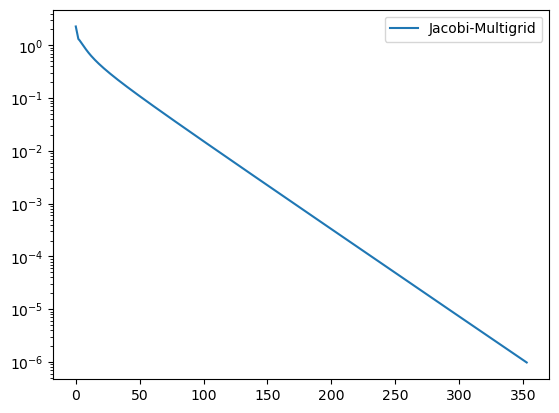

In [7]:
with torch.no_grad():
    n = n_test
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, pacnet=None, device=device, nb_layers=3, mode=mode, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(f_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = EPS*torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')
    
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()


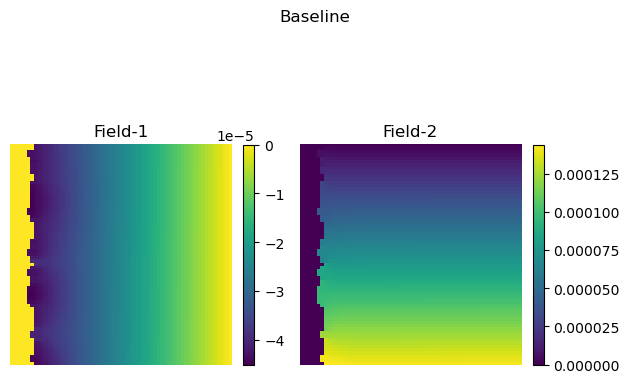

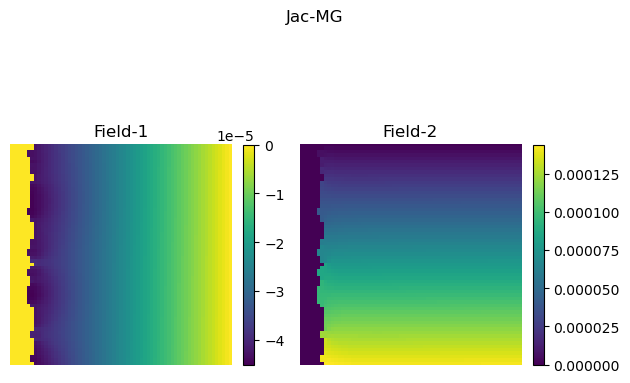

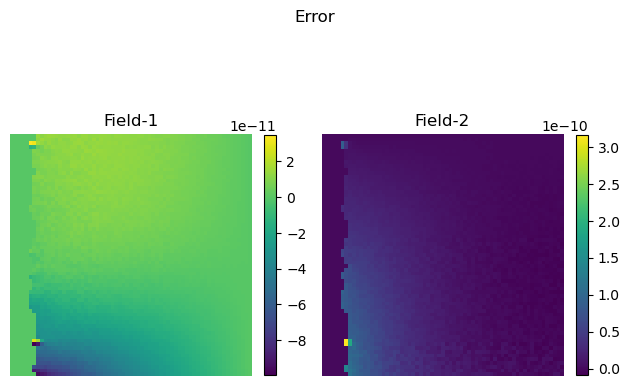

In [8]:
plot.plot_elasticfield(solution_test[k], ftitle='Baseline')
plot.plot_elasticfield(u_mg_jac[k], ftitle='Jac-MG')
plot.plot_elasticfield(solution_test[k]-u_mg_jac[k], ftitle='Error')

In [9]:
from feanet.post_processing import ElasticPostProcessing
ePost = ElasticPostProcessing(h, 'elastic_pstress', m_test.float(), emsk_test.float(), nmsk_test.float())
ePost.ComputeStrain(u_mg_jac.float())
ePost.ComputeStress(u_mg_jac.float())
energy = ePost.ComputeStrainEnergyDensity()

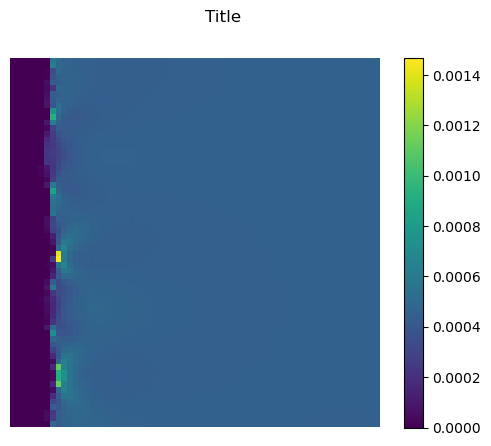

In [10]:
plot.plot_thermalfield(energy[0])

Test two-phase material system

In [ ]:
bs = 5
train_dataloader = DataLoader(test_set, batch_size=bs, shuffle=False)
dirich_idx_train, dirich_value_train, neumann_idx_train, neumann_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k=1
solution_test, f_test, d_test, d_idx_test, t_test, t_idx_test, m_test = (torch.unsqueeze(u_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_train[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_train[k], 0).to(device_predict))


In [ ]:
plot.plot_elasticfield(d_idx_test[0], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(d_test[0], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(t_idx_test[0], ftitle='Traction boundary index')
plot.plot_elasticfield(t_test[0], ftitle='Traction boundary value')
plot.plot_elasticfield(m_test[0], ftitle='Material map (E, v)')
plot.plot_elasticfield(f_test[0], ftitle='Body force')
plot.plot_elasticfield(solution_test[0], ftitle='Solution')

In [ ]:
with torch.no_grad():
    n = n_test
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, mode='elastic', iterator='jac') # create a multigrid model
    u_mg_jac = torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_jac,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_jac = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


In [ ]:
with torch.no_grad():
    h = 2./n
    n_mg_jac = 0
    mg_jac = MultiGrid(n=n, pacnet=my_net, device=device, nb_layers=nb_layers, mode='elastic', iterator='psi') # create a multigrid model
    u_mg_psi = torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    mg_jac.ProblemDictArray(u_mg_psi,f_test,t_test,t_idx_test,d_test,d_idx_test,m_test)
    u_mg_psi = mg_jac.p_arr[0]['u0']
    residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgpsi = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_psi = mg_jac.Step(u_mg_psi)
        #u_mg = mg_jac.Relax(mg_jac.iterators[0], u_mg, m_test, d_test,d_idx_test, None, None, h, f_test, t_test, t_idx_test, 1)
        residual = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
        res = torch.norm(residual).item()
        res_arr_mgpsi.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Psi-Jacobi multigrid iterations in", end-start, 'seconds.')


In [ ]:
plt.plot(res_arr_mgjac, label='MG-$\Psi_J$')
plt.plot(res_arr_mgpsi, label='MG-$\Psi_H$')
plt.yscale('log')
plt.xlabel('# iterations')
plt.ylabel('|r|')
plt.legend(prop={'size':18})
plt.show()

In [ ]:
plot.plot_elasticfield(solution_test[0], 'True solution', 'U1', 'U2')

In [ ]:
plot.plot_elasticfield(u_mg_psi[0], 'Psi solution', 'U1', 'U2')

In [ ]:
res_jac = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, f_test, t_test, t_idx_test, m_test)
plot.plot_elasticfield(torch.abs(res_jac[0]), 'Residual of Jacobi-Multigrid')

In [ ]:
res_psi = d_idx_test*mg_jac.iterators[0].grid.net(None, None, h, u_mg_psi, f_test, t_test, t_idx_test, m_test)
plot.plot_elasticfield(torch.abs(res_psi[0]), 'Residual of Psi-Multigrid', 'R1', 'R2')

In [ ]:
res_jac_flat = torch.flatten(res_jac*d_idx_test).cpu().detach().numpy()
res_psi_flat = torch.flatten(res_psi*d_idx_test).cpu().detach().numpy()

plt.hist(res_jac_flat, bins=30, label='Jacobi-Multigrid')
plt.hist(res_psi_flat, bins=30, label='Psi-Multigrid')

plt.xlabel('r')
plt.legend()
plt.ylabel('frequency')